In [ ]:
# default_exp samplers

# Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction circuits

In [ ]:
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import qsam.samptools as math
import qsam.circtools as ct
from qsam.chp_simulator import CHP
from qsam.fault_generators import Depolar

import numpy as np
import itertools as it

In [ ]:
#export
ONE_QUBIT_GATES = {'H', 'X', 'Z'}
TWO_QUBIT_GATES = {'CNOT'}

GATE_GROUPS = {'p': ONE_QUBIT_GATES | TWO_QUBIT_GATES,
               'p1': ONE_QUBIT_GATES,
               'p2': TWO_QUBIT_GATES }

In [ ]:
#export
class Sampler:
    """Sampler base class"""
    
    def __init__(self, circuit, err_params):
        self.circuit = circuit
        self.n_qubits = circuit.n_qubits
        self.partitions = [ct.partition(circuit, GATE_GROUPS[g]) for g in err_params.keys()]
        self.p_phys_mat = np.vstack(list(err_params.values())).T # p_phy_range x partitions

    def _sample(self, err_gen=None, p_phys=None):
        sim = CHP(self.n_qubits)
        err_circuit = None if err_gen==None else err_gen.generate(self.partitions, p_phys)
        msmt = sim.run(self.circuit, err_circuit)
        return msmt

    def _check_logical_failure(self, msmt): # THIS SHOULD BE DEFINED SOMEWHERE ELSE.
        return 1 if msmt else 0 

In [ ]:
#export
class DirectSampler(Sampler):
    """Direct Monte Carlo sampler"""

    def __init__(self, circuit, err_params):
        super().__init__(circuit, err_params)
        choose_fn = lambda l,p: set(i for i in l if np.random.random() < p)
        self.err_gen = Depolar(choose_fn=choose_fn, n_ticks=len(circuit))

    def run(self, n_samples=100, var=math.Wilson_var):
        fail_cnts = np.zeros((self.p_phys_mat.shape[0])) # one fail counter per p_phys

        for i, p_phys in enumerate(self.p_phys_mat):
            for _ in range(n_samples):
                msmt = self._sample(self.err_gen, p_phys)
                fail_cnts[i] += self._check_logical_failure(msmt)

        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std

Let's see how the direct sampler works

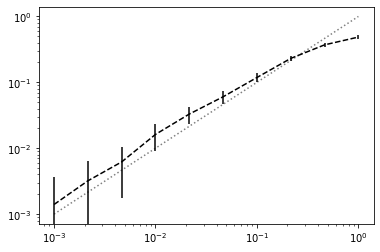

In [ ]:
from qsam.circuit import Circuit

ghz = Circuit([ {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

import numpy as np

# p = np.logspace(-3,0,10)
# err_params = {'p': p}
p1 = np.logspace(-3,0,10)
p2 = 0.5 * p1
err_params = {'p1':p1, 'p2':p2}

ds = DirectSampler(ghz, err_params)
p_L, std = ds.run(n_samples=5000)

import matplotlib.pyplot as plt

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std)
plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')

In [ ]:
#export
class SubsetSampler(Sampler):
    """Monte Carlo subset sampler"""
    
    def __init__(self, circuit, err_params):
        super().__init__(circuit, err_params)
        choose_fn = lambda l,k: [l[i] for i in np.random.choice(len(l),k,replace=False)]
        self.err_gen = Depolar(choose_fn=choose_fn, n_ticks=circuit.n_ticks)

    def _monte_carlo(self, w_vecs, n_samples, SS_sel_fn):
        """Generate 1D list of subset failure rates per weight vector combi"""
        cnts      = np.zeros((len(w_vecs))) + 1 # one virtual sample to avoid div0
        fail_cnts = np.zeros((len(w_vecs))) 
        idx = 0 # Needed for Metropolis SS selector (if chosen)

        for i in range(n_samples):
            idx = SS_sel_fn(cnts, fail_cnts, curr_idx=idx)
            w_vec = w_vecs[idx]
            msmt = self._sample(self.err_gen, w_vec)
            fail_cnts[idx] += self._check_logical_failure(msmt)
            cnts[idx] += 1

        return fail_cnts, cnts - 1 # remove virtual sample

    def _find_weights(self, p_max, delta_max):
        """Find w_max vector for delta_max at p_max"""
        assert len(p_max) == len(delta_max) == len(self.partitions)
        w_cutoff = np.zeros_like(p_max, dtype=int)
        for i in range(len(w_cutoff)):
            w_cutoff[i] = math.weight_cutoff(p_max[i], delta_max[i], len(self.partitions[i]))
        # Generate weight vectors (combis of all ws up to each w_max per partition)
        w_vecs = list(it.product( *[list(range(w_cutoff_i+1)) for w_cutoff_i in w_cutoff] ))
        return w_vecs

    def _calc_binomial_weights(self, w_vecs):
        """Calculate 3D tensor of binom. coefs for each partition"""
        partition_lens = np.array([len(p) for p in self.partitions])
        Aws = np.array([math.binom(w_vec, partition_lens, self.p_phys_mat) for w_vec in w_vecs])
        Aws = np.product(Aws, axis=-1) # get list of Aw for each partition SS combination
        return Aws

    def _calc_stats(self, Aws, pws, n_samples, var=math.Wilson_var):
        """Calculate failure rates and std"""
        p_L_low = np.sum(Aws * pws, axis=0)
        p_L_up = p_L_low + 1 - np.sum(Aws, axis=0)
        std = math.std_sum(Aws, pws, n_samples, var)
        return p_L_up, p_L_low, std
            
    def run(self, p_max, delta_max, n_samples=20, var=math.Wilson_var, SS_sel_fn=math.balanced_SS_selector):

        w_vecs = self._find_weights(p_max, delta_max)
        fail_cnts, cnts = self._monte_carlo(w_vecs, n_samples, SS_sel_fn)

        pws = (fail_cnts/ cnts)[:,None]
        Aws = self._calc_binomial_weights(w_vecs)
        return self._calc_stats(Aws, pws, n_samples, var)

Let's see how the subset sampler works:

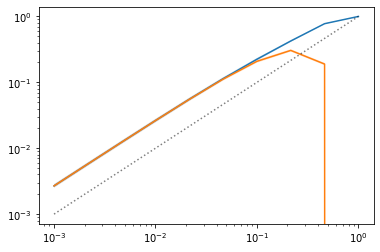

In [ ]:
from qsam.circuit import Circuit

ghz = Circuit([ {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

import numpy as np

p = np.logspace(-3,0,10)
err_params = {'p': p}

ds = SubsetSampler(ghz, err_params)
p_L_low, p_L_up, std = ds.run(p_max=[0.1], delta_max=[0.1], n_samples=5000)

import matplotlib.pyplot as plt

plt.plot(p1, p_L_low, label="SS low")
plt.fill_between(p1, p_L_low-std, p_L_low+std, alpha=0.2)
plt.plot(p1, p_L_up, label="SS up")
plt.fill_between(p1, p_L_up-std, p_L_up+std, alpha=0.2)
plt.plot(p1,p1, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')

**TODO** Tests and example